# 6.0002 Lecture 14: Classification and Statistical Sins

**Speaker:** Prof. John Guttag

## Helper code from last lecture

In [1]:
import pylab, random

In [2]:
#set line width
pylab.rcParams['lines.linewidth'] = 4
#set font size for titles 
pylab.rcParams['axes.titlesize'] = 20
#set font size for labels on axes
pylab.rcParams['axes.labelsize'] = 20
#set size of numbers on x-axis
pylab.rcParams['xtick.labelsize'] = 16
#set size of numbers on y-axis
pylab.rcParams['ytick.labelsize'] = 16
#set size of ticks on x-axis
pylab.rcParams['xtick.major.size'] = 7
#set size of ticks on y-axis
pylab.rcParams['ytick.major.size'] = 7
#set size of markers
pylab.rcParams['lines.markersize'] = 10
#set number of examples shown in legends
pylab.rcParams['legend.numpoints'] = 1

In [3]:
def minkowskiDist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
       Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1/p)

In [5]:
def getTitanicData(fname):
    data = {}
    data['class'], data['survived'], data['age'] = [], [], []
    data['gender'], data['name'] = [], []
    f = open(fname)
    line = f.readline()
    while line != '':
        split = line.split(',')
        data['class'].append(int(split[0]))
        data['age'].append(float(split[1]))
        if split[2] == 'M':
            data['gender'].append(1)
        else:
            data['gender'].append(0)
        if split[3] == '1':
            data['survived'].append('Survived')
        else:
            data['survived'].append('Died')
        data['name'].append(split[4:])
        line = f.readline()
    return data
                
def buildTitanicExamples(fileName):
    data = getTitanicData(fileName)
    examples = []
    for i in range(len(data['class'])):
        p = Passenger(data['class'][i], data['age'][i],
                      data['gender'][i], data['survived'][i],
                      data['name'][i])
        examples.append(p)
    print('Finished processing', len(examples), 'passengers\n')    
    return examples

In [6]:
def accuracy(truePos, falsePos, trueNeg, falseNeg):
    numerator = truePos + trueNeg
    denominator = truePos + trueNeg + falsePos + falseNeg
    return numerator/denominator

def sensitivity(truePos, falseNeg):
    try:
        return truePos/(truePos + falseNeg)
    except ZeroDivisionError:
        return float('nan')
    
def specificity(trueNeg, falsePos):
    try:
        return trueNeg/(trueNeg + falsePos)
    except ZeroDivisionError:
        return float('nan')
    
def posPredVal(truePos, falsePos):
    try:
        return truePos/(truePos + falsePos)
    except ZeroDivisionError:
        return float('nan')
    
def negPredVal(trueNeg, falseNeg):
    try:
        return trueNeg/(trueNeg + falseNeg)
    except ZeroDivisionError:
        return float('nan')
       
def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint = True):
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg)
    sens = sensitivity(truePos, falseNeg)
    spec = specificity(trueNeg, falsePos)
    ppv = posPredVal(truePos, falsePos)
    if toPrint:
        print(' Accuracy =', round(accur, 3))
        print(' Sensitivity =', round(sens, 3))
        print(' Specificity =', round(spec, 3))
        print(' Pos. Pred. Val. =', round(ppv, 3))
    return (accur, sens, spec, ppv)

In [7]:
def split80_20(examples):
    sampleIndices = random.sample(range(len(examples)),
                                  len(examples)//5)
    trainingSet, testSet = [], []
    for i in range(len(examples)):
        if i in sampleIndices:
            testSet.append(examples[i])
        else:
            trainingSet.append(examples[i])
    return trainingSet, testSet
    
def randomSplits(examples, method, numSplits, toPrint = True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    random.seed(0)
    for t in range(numSplits):
        trainingSet, testSet = split80_20(examples)
        results = method(trainingSet, testSet)
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    getStats(truePos/numSplits, falsePos/numSplits,
             trueNeg/numSplits, falseNeg/numSplits, toPrint)
    return truePos/numSplits, falsePos/numSplits,\
             trueNeg/numSplits, falseNeg/numSplits

In [8]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [9]:
def buildModel(examples, toPrint = True):
    featureVecs, labels = [],[]
    for e in examples:
        featureVecs.append(e.getFeatures())
        labels.append(e.getLabel())
    model = LogisticRegression().fit(featureVecs, labels)
    if toPrint:
        print('model.classes_ =', model.classes_)
        for i in range(len(model.coef_)):
            print('For label', model.classes_[1])
            for j in range(len(model.coef_[0])):
                print('   ', Passenger.featureNames[j], '=',
                      model.coef_[0][j])
    return model

def applyModel(model, testSet, label, prob = 0.5):
    testFeatureVecs = [e.getFeatures() for e in testSet]
    probs = model.predict_proba(testFeatureVecs)
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(probs)):
        if probs[i][1] > prob:
            if testSet[i].getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else:
            if testSet[i].getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

In [10]:
# logistic regression
def lr(trainingData, testData, prob = 0.5):
    model = buildModel(trainingData, False)
    results = applyModel(model, testData, 'Survived', prob)
    return results

## Looking at feature weights
- model.classes_ = ['Died', 'Survived']
- for label survived: 
    - C1 = 1.66761946545
    - C2 = 0.46035455245
    - C3 = -0.50338282535
    - age = -0.03144810623
    - male gender = -2.39514860929
- be wary of reading too much into the weights
- features are often correlated
- L1 regression tends to drive one variable to zero
- L2 (default) regression spreads weights across variables    

## Correlated Features, an example
- c1 + c2 + c3 = 1
    - i.e. values are not independent
    - is being in 1st class good, or being in the other classes bad?
- suppose we eliminate c1?

In [4]:
# remove first class (C1)
class Passenger(object):
#    featureNames = ('C1', 'C2', 'C3', 'age', 'male gender')
#    def __init__(self, pClass, age, gender, survived, name):
#        self.name = name
#        self.featureVec = [0, 0, 0, age, gender]
#        self.featureVec[pClass - 1] = 1
#        #self.featureVec[0] = 0 #Ugly hack
#        self.label = survived
#        self.cabinClass = pClass
    featureNames = ('C2', 'C3', 'age', 'male gender')  # now only 4 features
    def __init__(self, pClass, age, gender, survived, name):
        self.name = name
        if pClass == 2:
            self.featureVec = [1, 0, age, gender]
        elif pClass == 3:
            self.featureVec = [0, 1, age, gender]
        else:
            self.featureVec = [0, 0, age, gender]
        self.label = survived
        self.cabinClass = pClass
    def distance(self, other):
        return minkowskiDist(self.featureVec, other.featureVec, 2)
    def getClass(self):
        return self.cabinClass
    def getAge(self):
        return self.featureVec[3]
    def getGender(self):
        return self.featureVec[4]
    def getName(self):
        return self.name
    def getFeatures(self):
        return self.featureVec[:]
    def getLabel(self):
        return self.label

## New Results

In [11]:
examples = buildTitanicExamples('TitanicPassengers.txt')

random.seed(0)
numSplits = 20
print('Average of', numSplits, '80/20 splits LR')
truePos, falsePos, trueNeg, falseNeg =\
      randomSplits(examples, lr, numSplits)

#Look at weights
trainingSet, testSet = split80_20(examples)
model = buildModel(trainingSet, True)

Finished processing 1046 passengers

Average of 20 80/20 splits LR
 Accuracy = 0.778
 Sensitivity = 0.683
 Specificity = 0.845
 Pos. Pred. Val. = 0.758
model.classes_ = ['Died' 'Survived']
For label Survived
    C2 = -1.2220347359272548
    C3 = -2.0992389657948607
    age = -0.03162164116492356
    male gender = -2.4334594390733986


- weights are quite different
- C2 and C3 now have strong negative weights
- age and gender weights only changed slightly

## Changing the cutoff

In [12]:
# look at changing probability (p)
random.seed(0)
trainingSet, testSet = split80_20(examples)
model = buildModel(trainingSet, False)

print('Try p = 0.1')
truePos, falsePos, trueNeg, falseNeg =\
                   applyModel(model, testSet, 'Survived', 0.1)
getStats(truePos, falsePos, trueNeg, falseNeg)

print('Try p = 0.9')
truePos, falsePos, trueNeg, falseNeg =\
                   applyModel(model, testSet, 'Survived', 0.9)
getStats(truePos, falsePos, trueNeg, falseNeg)

Try p = 0.1
 Accuracy = 0.493
 Sensitivity = 0.976
 Specificity = 0.161
 Pos. Pred. Val. = 0.444
Try p = 0.9
 Accuracy = 0.656
 Sensitivity = 0.176
 Specificity = 0.984
 Pos. Pred. Val. = 0.882


(0.6555023923444976,
 0.17647058823529413,
 0.9838709677419355,
 0.8823529411764706)

- by changing probability, we make decision that is more important to not miss survivors than it is to guess too high
- p = 0.9 gives higher accuracy
- key difference: going from p=0.1 to p=0.9 drastically decreased sensitivity
- accuracy stays relatively the same, since most people died

## Receiver operating characteristic (ROC)
- don't want to make a decision about the cutoff
- look at all possible cutoffs instead
- build one model, vary p, and apply the model with same test set but different p
    - keep track of all the results
    - plot sensitivity versus 1 - specificity

In [15]:
def buildROC(trainingSet, testSet, title, plot = True):
    model = buildModel(trainingSet, True)
    xVals, yVals = [], []
    p = 0.0
    while p <= 1.0:
        truePos, falsePos, trueNeg, falseNeg =\
                               applyModel(model, testSet,
                               'Survived', p)
        xVals.append(1.0 - specificity(trueNeg, falsePos))
        yVals.append(sensitivity(truePos, falseNeg))
        p += 0.01
    auroc = sklearn.metrics.auc(xVals, yVals)  # area under the curve
    if plot:
        pylab.plot(xVals, yVals)
        pylab.plot([0,1], [0,1])
        title = title + '\nAUROC = ' + str(round(auroc,3))
        pylab.title(title)
        pylab.xlabel('1 - specificity')
        pylab.ylabel('Sensitivity')
    return auroc

model.classes_ = ['Died' 'Survived']
For label Survived
    C2 = -1.3714731011951065
    C3 = -2.2428284865863897
    age = -0.03746028761976204
    male gender = -2.2877027913042673


0.860246679316888

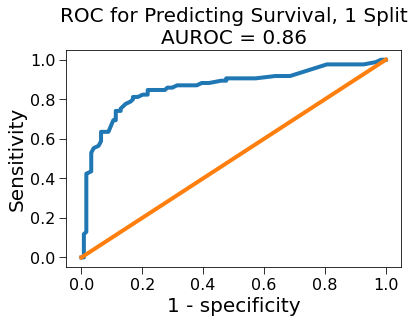

In [16]:
random.seed(0)
trainingSet, testSet = split80_20(examples)
buildROC(trainingSet, testSet, 'ROC for Predicting Survival, 1 Split')

- orange line represents a random classifier
- area between blue curve and random classifier tells you how much better than random
- whole area: area under receiver operating curve (AUROC)
    - perfect classifier: this would be 1
    - random (0.5) is as bad as you can do

## There are three kinds of lies
- lies
- damned lies
- STATISTICS
- *Prof. Guttag puts on his "numbers never lie" cap*

## Humans and statistics
- "*If you can't prove what you want to prove, demonstrate something else and pretend they are the same thing. In the daze that follows the collision of statistics with the human mind, hardly anyone will notice the difference.*" -- Darrell Huff

## Summary statistics
- four groups each containing 11 x, y pairs
- summary statistics for groups identical:
    - mean x = 9.0
    - mean y = 7.5
    - variance of x = 10.0
    - variance of y = 3.75
    - linear regression model: y = 0.5x + 3 (for all four groups)
- are four data sets really similar?
    - their plots are entirely different
- moral: statistics about data is not the same as the data
- moral: use visualization tools to look at the data itself

## Lying vs. telling the truth with pictures
- look carefully at the axis labels and scales
- ask whether the thigns being compared are actually comparable

## Garbage In, Garbage Out
- "*On two occasions, I have been asked [by members of parliament] 'Pray, Mr. Babbage, if you put into the machine the wrong figures, will the right answers come out?' I am not able rightly to apprehend the kind of confusion of ideas that could provoke such a question.*" -- Charles Babbage (1791-1871)

## Calhoun's response to errors in data
- "*there were so many errors they balanced one another, and led to the same conclusions as if they were all correct.*"
- Was it the case that the measurement errors are unbiased and independent of each other, and therefore almost identically distributed on either side of the mean?
- No, later analysis showed that the errors were not random but systematic.
- "*it was the census that was insane and not the colored people.*" -- James Freeman Clarke
- Moral: analysis of bad data can lead to dangerous conclusions. 

## sampling
- all statistical techniques are based upon the assumption that by sampling a subset of a population, we can infer things about the population as a whole
- as we have seen, *if random sampling is used*, one can make meaningful mathematical statements about the expected relation of the sample to the entire population
- easy to get random samples in simulations
- not so easy in the field, where some examples are more convenient to acquire than others

## non-representative sampling
- "convenience sampling" not usually random, e.g., 
    - survivor bias, e.g., course evaluations at end of course or grading final exam in 6.0002 on a strict curve
    - non-response bias, e.g., opinion polls conducted by mail or online
- when samples not random and independent, we can still do things like computer means and standard deviations, but **we should not draw conclusions from them** using things like the empirical rule and central limit theorem
- moral: understand how data was collected, and whether assumptions used in the analysis are satisfied